In [1]:
import pymks
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
def draw_im(x_data, scale = 6):
    g_num = 1.61803398
    plt.rcParams["figure.figsize"] = (scale*g_num, scale)
    plt.imshow(x_data)
    plt.colorbar()
    plt.show()

In [3]:
import numpy as np
import dask.array as da
from toolz.curried import curry, pipe, compose
from pymks.filter import Filter
from scipy.ndimage.fourier import fourier_gaussian
from pymks.datasets.base_microstructure_generator import _BaseMicrostructureGenerator


from pymks.fmks.func import fftn, ifftn, fftshift, ifftshift, fmap

conj = curry(np.conjugate)
fabs = curry(np.absolute)

In [4]:
class MicrostructureGenerator(_BaseMicrostructureGenerator):
    """
    Generates n_samples number of a periodic random microstructures
    with domain size equal to size and with n_phases number of
    phases. The optional grain_size argument controls the size and
    shape of the grains.

    >>> n_samples, n_phases = 1, 2
    >>> size = (4, 4)
    >>> generator = MicrostructureGenerator(n_samples, size,
    ...                                      n_phases, seed=10)
    >>> X = generator.generate()
    >>> X_test = np.array([[[1, 0, 1, 1],
    ...                     [1, 0, 0, 1],
    ...                     [0, 0, 1, 1],
    ...                     [0, 1, 1, 1]]])
    >>> assert(np.allclose(X, X_test))

    """

    def generate(self):
        """
        Generates a microstructure of dimensions of self.size and grains
        with dimensions self.grain_size.

        Returns:
          periodic microstructure
        """
        if len(self.size) != len(self.grain_size):
            raise RuntimeError("Dimensions of size and grain_size are"
                               " not equal.")

        X = np.random.random((self.n_samples,) + self.size)
        _gaussian_size = np.around(self.grain_size).astype(int)
        gaussian = fourier_gaussian(np.ones(_gaussian_size),
                                    np.ones(len(self.size)))
        filter_ = Filter(self._fftn(gaussian[None, ..., None]), self)
        filter_.resize(self.size)
        X_blur = filter_.convolve(X[..., None]).real
        return self._assign_phases(X_blur).astype(int)

    def _assign_phases(self, X_blur):
        """
        Takes in blurred array and assigns phase values.

        Args:
          X_blur: random field that has be blurred by a convolution.
        Returns:
          microstructure with assigned phases
        """
        if self.volume_fraction is None:
            epsilon = 1e-5
            X0, X1 = np.min(X_blur), np.max(X_blur)
            Xphases = float(self.n_phases) * ((X_blur - X0) / (X1 - X0) *
                                              (1. - epsilon) + epsilon)
            X_phases = np.floor(Xphases - epsilon)
        else:
            v_cum = np.cumsum(self.volume_fraction[:-1])
            X_sort = np.sort(X_blur.reshape((X_blur.shape[0], -1)), axis=1)
            seg_shape = (len(X_sort), len(v_cum))
            per_diff = (2 * np.random.random(seg_shape) -
                        1) * np.array(self.percent_variance)
            seg_ind = np.floor((v_cum + per_diff) *
                               X_sort.shape[1]).astype(int)
            seg_values = np.concatenate([x[list(i)][None]
                                         for i, x in zip(seg_ind, X_sort)])
            new_axes = [None for i in X_blur[0].shape]
            seg_slices = [slice(None)] + new_axes + [slice(None)]
            X_bool = X_blur[..., None] > seg_values[tuple(seg_slices)]
            X_phases = np.sum(X_bool, axis=-1)
        return X_phases

    
def make_microstructure(n_samples=10, size=(101, 101), n_phases=2,
                        grain_size=None, seed=10, volume_fraction=None,
                        percent_variance=None):
    """
    Constructs microstructures for an arbitrary number of phases
    given the size of the domain, and relative grain size.

    Args:
        n_samples (int, optional): number of samples
        size (tuple, optional): dimension of microstructure
        n_phases (int, optional): number of phases
        grain_size (tuple, optional): effective dimensions of grains
        seed (int, optional): seed for random number microstructureGenerator
        volume_fraction(tuple, optional): specify the volume fraction of each
            phase
        percent_variance(int, optional): varies the volume fraction of the
            microstructure up to this percentage

    Returns:
        microstructures for the system of shape (n_samples, n_x, ...)

    Example

    >>> n_samples, n_phases = 1, 2
    >>> size, grain_size = (3, 3), (1, 1)
    >>> Xtest = np.array([[[0, 1, 0],
    ...                [0, 0, 0],
    ...                [0, 1, 1]]])
    >>> X = make_microstructure(n_samples=n_samples, size=size,
    ...                         n_phases=n_phases, grain_size=grain_size,
    ...                         seed=0)

    >>> assert(np.allclose(X, Xtest))

    """
    if grain_size is None:
        grain_size = np.array(size) / 3.
    if np.sum(np.array(grain_size) > np.array(size)):
        raise RuntimeError('grain_size must be smaller than size')
    MS = MicrostructureGenerator(n_samples=n_samples, size=size,
                                 n_phases=n_phases, grain_size=grain_size,
                                 seed=seed, volume_fraction=volume_fraction,
                                 percent_variance=percent_variance)
    return MS.generate()

In [5]:
@curry
def imfilter(x_data, f_data):
    """
    to convolve f_data over x_data
    """
    return pipe(f_data,
                ifftshift,
                fftn,
                lambda x: conj(x)*fftn(x_data),
                ifftn,
                fabs)


@curry
def zero_pad(arr, shape):
    if len(shape) != len(arr.shape):
        raise RuntimeError("length of shape is incorrect")

    if not np.all(shape >= arr.shape):
        raise RuntimeError("resize shape is too small")

    return pipe(
        np.array(shape) - np.array(arr.shape),
        lambda x: np.concatenate(
            ((x - (x // 2))[..., None], (x // 2)[..., None]), axis=1
        ),
        fmap(tuple),
        tuple,
        lambda x: np.pad(arr, x, "constant", constant_values=0),
    )

@curry
def gaussian_blur_filter(grain_size, domain_size):
    return pipe(grain_size, 
                lambda x: fourier_gaussian(np.ones(x), np.ones(len(x))), 
                fftshift,
                zero_pad(shape=domain_size))


@curry
def get_segmentation_values(x_data, num_samples, volume_fraction, num_phases):
    if volume_fraction is None:
        cumsum = pipe(num_phases, 
                      lambda x: [1/x] * x, 
                      lambda x: np.cumsum(x)[:-1])
    elif len(volume_fraction) == num_phases:
        cumsum = np.cumsum(volume_fraction)[:-1]

    return pipe(x_data, 
                lambda x: np.reshape(x, (num_samples,-1)),
                lambda x: np.quantile(x, q=cumsum, axis=1).T,
                lambda x: np.reshape(x, [num_samples,]+[1]*(x_data.ndim-1)+[num_phases-1,]))

@curry
def generate(num_samples=5,
             domain_size = (101, 101), 
             grain_size= (25, 50), 
             num_phases = 5, 
             volume_fraction=None, 
             seed=10):

    np.random.seed(seed)
    seg_values = get_segmentation_values(num_samples=num_samples, 
                                         volume_fraction=volume_fraction, 
                                         num_phases=num_phases)

    return pipe((num_samples,) + domain_size,
                lambda x: np.random.random(x),
                imfilter(f_data=gaussian_blur_filter(grain_size, domain_size)),
                lambda x: x[...,None] > seg_values(x),
                lambda x: np.sum(x, axis=-1))

In [6]:
n_samples = 5
m_size = (101, 101)
g_size= (25, 50,)
n_phases = 10
volume_fraction = [1/n_phases] * n_phases

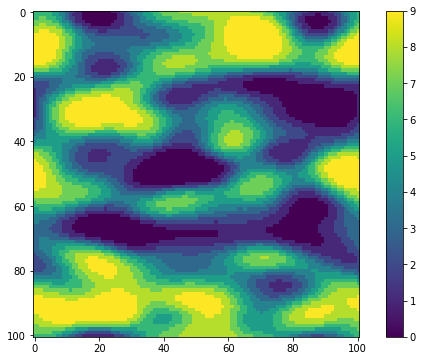

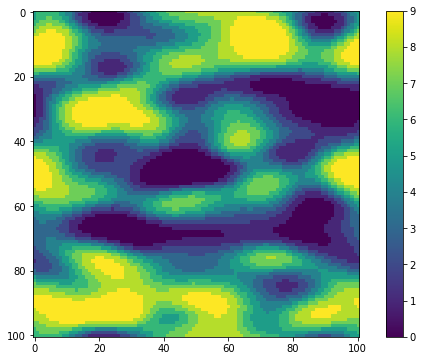

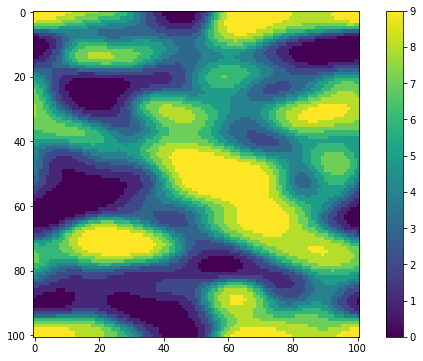

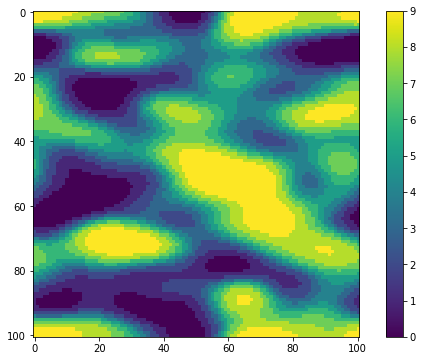

In [7]:
x_pymks = make_microstructure(n_samples=n_samples,
                                size=m_size,
                                grain_size=g_size, 
                                n_phases=n_phases,
                                seed=10,
                                volume_fraction=volume_fraction)


x_fmks = generate(num_samples=n_samples, 
                  domain_size = m_size, 
                  grain_size=  g_size, 
                  num_phases = n_phases, 
                  volume_fraction=volume_fraction, 
                  seed=10)



draw_im(x_fmks[0,...])
draw_im(x_pymks[0,...])

draw_im(x_fmks[-1,...])
draw_im(x_pymks[-1,...])